# Analisis de negocio

En este proyecto realizaremos un proceso completo de analisis de conversion de eventos y de pruebas A/B

## Parte 1. Importación y corrección de datos

In [41]:
# importación de librerias pertinentes
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# importación y revision inicial de los datos
ordenes = pd.read_csv('logs_exp_us.csv', sep='\t')
print(ordenes.head())
print(ordenes.info())

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


In [3]:
# conversión de datos de objeto a fecha
ordenes['EventTimestamp'] = pd.to_datetime(ordenes['EventTimestamp'], unit='s')
print(ordenes['EventTimestamp'].tail())

# creación de columna en el que se almacena solo la fecha del evento
ordenes['EventDate'] = pd.to_datetime(ordenes['EventTimestamp'], unit='s').dt.date
print(ordenes['EventDate'].tail())

244121   2019-08-07 21:12:25
244122   2019-08-07 21:13:59
244123   2019-08-07 21:14:43
244124   2019-08-07 21:14:58
244125   2019-08-07 21:15:17
Name: EventTimestamp, dtype: datetime64[ns]
244121    2019-08-07
244122    2019-08-07
244123    2019-08-07
244124    2019-08-07
244125    2019-08-07
Name: EventDate, dtype: object


## Parte 3. Estudio de los datos

In [44]:
print(f"Numero de eventos unicos: {ordenes['EventName'].nunique()}")
print(f"Numero de usuarios unicos: {ordenes['DeviceIDHash'].nunique()}")

Numero de eventos unicos: 5
Numero de usuarios unicos: 7551


In [46]:
promedio_eventos = ordenes.groupby('DeviceIDHash').size().mean()
print(f"Promedio de eventos por usuario: {promedio_eventos}")

Promedio de eventos por usuario: 32.33028737915508


In [47]:
print(f"Primer registro de evento: {ordenes['EventTimestamp'].min()}")
print(f"Ultimo registro de evento: {ordenes['EventTimestamp'].max()}")

Primer registro de evento: 2019-07-25 04:43:36
Ultimo registro de evento: 2019-08-07 21:15:17


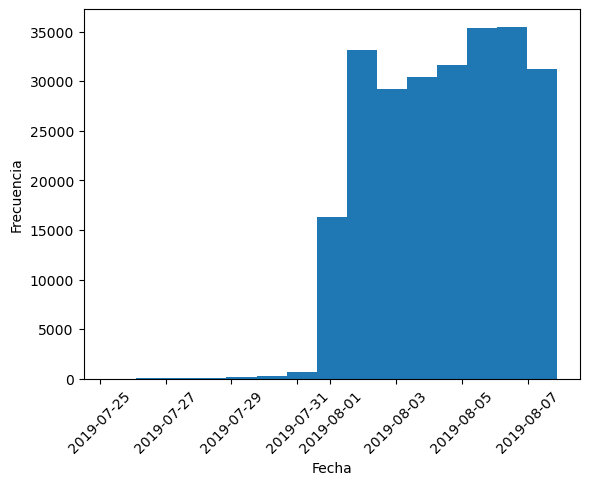

In [48]:
plt.hist(ordenes['EventTimestamp'],bins=15)
plt.xticks(rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.show()

In [49]:
# Creación de df que contemple únicamente los eventos en fechas pertinentes
ordenes_2 = ordenes[ordenes['EventTimestamp'] >= '2019-07-31']
print(ordenes_2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 243329 entries, 797 to 244125
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   EventName       243329 non-null  object        
 1   DeviceIDHash    243329 non-null  int64         
 2   EventTimestamp  243329 non-null  datetime64[ns]
 3   ExpId           243329 non-null  int64         
 4   EventDate       243329 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.1+ MB
None


Se perdieron al rededor de 1000 registros, aceptable para la continuación del estudio y análisis de datos

In [50]:
print(f"Grupos de experimento en el nuevo df: {ordenes_2['ExpId'].nunique()}")

Grupos de experimento en el nuevo df: 3


## Parte 4. Embudo de eventos

In [51]:
# Evento con mayor frecuencia
EventRep = ordenes_2['EventName'].value_counts()
print(EventRep)

EventName
MainScreenAppear           118681
OffersScreenAppear          46724
CartScreenAppear            42623
PaymentScreenSuccessful     34253
Tutorial                     1048
Name: count, dtype: int64


In [19]:
# Usuarios únicos por evento
users_per_event = ordenes_2.groupby('EventName')['DeviceIDHash'].nunique().sort_values(ascending=False)
print(users_per_event)

EventName
MainScreenAppear           7429
OffersScreenAppear         4606
CartScreenAppear           3742
PaymentScreenSuccessful    3542
Tutorial                    845
Name: DeviceIDHash, dtype: int64


In [20]:
# Proporción de usuarios unicos por evento
total_users = ordenes_2['DeviceIDHash'].nunique()
proportion = (users_per_event / total_users).sort_values(ascending=False)
print(proportion)

EventName
MainScreenAppear           0.985017
OffersScreenAppear         0.610713
CartScreenAppear           0.496155
PaymentScreenSuccessful    0.469637
Tutorial                   0.112039
Name: DeviceIDHash, dtype: float64


Parece ser que la si siguen una secuencia, salvo Tutorial, que podria ser parte o no, y la secuencia parace ser:
- MainScreenAppear
- OfferScreenAppear
- CartScreenAppear
- PaymentScreenSuccessful

In [26]:
# Filtrar los eventos relevantes
funnel_steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
funnel_df = ordenes_2[ordenes_2['EventName'].isin(funnel_steps)]

# Crear un DataFrame con usuarios y eventos únicos que realizaron
user_events = funnel_df.groupby('DeviceIDHash')['EventName'].unique()

# Paso 3: Chequear presencia en cada etapa
funnel_data = {
    'MainScreenAppear': user_events.apply(lambda x: 'MainScreenAppear' in x),
    'OffersScreenAppear': user_events.apply(lambda x: 'OffersScreenAppear' in x),
    'CartScreenAppear': user_events.apply(lambda x: 'CartScreenAppear' in x),
    'PaymentScreenSuccessful': user_events.apply(lambda x: 'PaymentScreenSuccessful' in x)
}

funnel_df_bool = pd.DataFrame(funnel_data)

# Paso 4: Conteos
step_A = funnel_df_bool['MainScreenAppear'].sum()
step_B = (funnel_df_bool['OffersScreenAppear'] & funnel_df_bool['MainScreenAppear']).sum()
step_C = (funnel_df_bool['OffersScreenAppear'] & funnel_df_bool['CartScreenAppear']).sum()
step_D = (funnel_df_bool['CartScreenAppear'] & funnel_df_bool['PaymentScreenSuccessful']).sum()

# Paso 5: Cálculo de proporciones
prop_AB = step_B / step_A if step_A else 0
prop_BC = step_C / step_B if step_B else 0
prop_CD = step_D / step_C if step_C else 0

# Mostrar resultados
print(f"Usuarios en MainScreenAppear: {step_A}")
print(f"Usuarios en OffersScreenAppear (de los que hicieron A): {step_B} → Proporción: {prop_AB:.2%}")
print(f"Usuarios en CartScreenAppear (de los que hicieron B): {step_C} → Proporción: {prop_BC:.2%}")
print(f"Usuarios en PaymentScreenSuccessful (de los que hicieron B): {step_D} → Proporción: {prop_CD:.2%}")

Usuarios en MainScreenAppear: 7429
Usuarios en OffersScreenAppear (de los que hicieron A): 4497 → Proporción: 60.53%
Usuarios en CartScreenAppear (de los que hicieron B): 3685 → Proporción: 81.94%
Usuarios en PaymentScreenSuccessful (de los que hicieron B): 3537 → Proporción: 95.98%


In [54]:
print(f"Proporción de usuarios que completaron el proceso completo: {3537/7429}%")

Proporción de usuarios que completaron el proceso completo: 0.4761071476645578%


## Parte 5. Resultados de los experimentos

In [55]:
print(f"Numero de usuarios unicos por grupo: {ordenes_2.groupby('ExpId')['DeviceIDHash'].nunique().sort_values(ascending=False)}")

Numero de usuarios unicos por grupo: ExpId
248    2540
247    2517
246    2485
Name: DeviceIDHash, dtype: int64


In [32]:
#Conversiones de cada grupo de control

group_246 = ordenes_2[ordenes_2['ExpId'] == 246]
group_247 = ordenes_2[ordenes_2['ExpId'] == 247]

def get_conversion_rate(df_group):
    total_users = df_group['DeviceIDHash'].nunique()
    converted_users = df_group[df_group['EventName'] == 'PaymentScreenSuccessful']['DeviceIDHash'].nunique()
    return converted_users, total_users, converted_users / total_users

converted_246, total_246, rate_246 = get_conversion_rate(group_246)
converted_247, total_247, rate_247 = get_conversion_rate(group_247)

# Valores para z-test
successes = [converted_246, converted_247]
totals = [total_246, total_247]

stat, pval = proportions_ztest(successes, totals)

print(f"Tasa de conversión Grupo 246: {rate_246:.2%}")
print(f"Tasa de conversión Grupo 247: {rate_247:.2%}")
print(f"p-valor: {pval:.4f}")

Tasa de conversión Grupo 246: 48.29%
Tasa de conversión Grupo 247: 46.05%
p-valor: 0.1121


In [37]:
#Funcion para calcular si existe diferencia estadística significativa entre los eventos de dos grupos

def test_event_difference(df, event_name, group_col='ExpId', user_col='DeviceIDHash', control_ids=(246, 247)):
    results = {}
    # Filtrar por grupos
    group_1 = df[df[group_col] == control_ids[0]]
    group_2 = df[df[group_col] == control_ids[1]]

    # Total de usuarios únicos por grupo
    total_1 = group_1[user_col].nunique()
    total_2 = group_2[user_col].nunique()

    # Usuarios que hicieron el evento
    users_event_1 = group_1[group_1['EventName'] == event_name][user_col].nunique()
    users_event_2 = group_2[group_2['EventName'] == event_name][user_col].nunique()

    # Proporciones
    prop_1 = users_event_1 / total_1
    prop_2 = users_event_2 / total_2

    # Prueba z
    count = [users_event_1, users_event_2]
    nobs = [total_1, total_2]
    stat, pval = proportions_ztest(count, nobs)

    results['event'] = event_name
    results['users_group1'] = users_event_1
    results['users_group2'] = users_event_2
    results['prop_group1'] = prop_1
    results['prop_group2'] = prop_2
    results['p_value'] = pval
    results['significant'] = pval < 0.05

    return results

In [38]:
# Obtener todos los eventos únicos
unique_events = ordenes_2['EventName'].unique()

# Ejecutar la prueba para cada evento
event_results1 = [test_event_difference(ordenes_2, event) for event in unique_events]

# Convertir en DataFrame
event_results_df1 = pd.DataFrame(event_results1).sort_values(by='p_value')

# Mostrar tabla
print(event_results_df1)

                     event  users_group1  users_group2  prop_group1  \
3  PaymentScreenSuccessful          1200          1159     0.482897   
4         CartScreenAppear          1267          1239     0.509859   
1       OffersScreenAppear          1544          1526     0.621328   
0         MainScreenAppear          2452          2479     0.986720   
2                 Tutorial           278           285     0.111871   

   prop_group2   p_value  significant  
3     0.460469  0.112108        False  
4     0.492253  0.213061        False  
1     0.606277  0.274351        False  
0     0.984903  0.586878        False  
2     0.113230  0.879161        False  


In [39]:
event_results2 = [test_event_difference(ordenes_2, event, group_col='ExpId', user_col='DeviceIDHash', control_ids=(246, 248)) for event in unique_events]
event_results_df2 = pd.DataFrame(event_results2).sort_values(by='p_value')
print(event_results_df2)

                     event  users_group1  users_group2  prop_group1  \
4         CartScreenAppear          1267          1236     0.509859   
3  PaymentScreenSuccessful          1200          1183     0.482897   
1       OffersScreenAppear          1544          1536     0.621328   
0         MainScreenAppear          2452          2498     0.986720   
2                 Tutorial           278           282     0.111871   

   prop_group2   p_value  significant  
4     0.486614  0.099417        False  
3     0.465748  0.223522        False  
1     0.604724  0.226997        False  
0     0.983465  0.341286        False  
2     0.111024  0.923947        False  


In [40]:
event_results3 = [test_event_difference(ordenes_2, event, group_col='ExpId', user_col='DeviceIDHash', control_ids=(247, 248)) for event in unique_events]
event_results_df3 = pd.DataFrame(event_results3).sort_values(by='p_value')
print(event_results_df3)

                     event  users_group1  users_group2  prop_group1  \
0         MainScreenAppear          2479          2498     0.984903   
4         CartScreenAppear          1239          1236     0.492253   
3  PaymentScreenSuccessful          1159          1183     0.460469   
2                 Tutorial           285           282     0.113230   
1       OffersScreenAppear          1526          1536     0.606277   

   prop_group2   p_value  significant  
0     0.983465  0.681958        False  
4     0.486614  0.688380        False  
3     0.465748  0.706589        False  
2     0.111024  0.803637        False  
1     0.604724  0.910052        False  


Con un nivel de significancia estadística del 0.05, podemos ver que no existe diferencia significativa entre grupos de control y el grupo con modificación, lo que significa que esperamos que haya menos de 1 error por azar en las pruebas que realizamos, exactamente se esperan 0.75 errores

# Conclusiones

Se llevo a cabo un procedimiento completo de analisis de negocio, en el que se utilizaron conocimientos de: 1.Procesamiento de datos 2.Analisis inicial de datos 3.Analisis estadistico 4.Analisis de negocio.

Con los resultados obtenidos podemos afirmar que la tasa de conversion es aproximada al 50% de los usuarios que interactuan con el servicio, y que las modificaciones en los procesos que llevan a la conversion no son los suficientes para ver un cambio significativo en la conversion